In [19]:
#1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import lightgbm as lgb
import shap
import joblib

In [4]:
df = pd.read_csv("Fraud.csv")

In [5]:
# For demo purposes, we'll sample 1M rows if the dataset is large
if len(df) > 1000000:
    df = df.sample(n=1000000, random_state=42)

## 2. Data Preprocessing
# Create isMerchant flag (assuming 'nameDest' exists in your actual data)
if 'nameDest' in df.columns:
    df['isMerchant'] = df['nameDest'].str.startswith('M').astype(int)
else:
    df['isMerchant'] = 0  # Default if column doesn't exist

In [6]:
# Create balance change features
if all(col in df.columns for col in ['oldbalanceOrg', 'newbalanceOrig']):
    df['balanceChangeOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
else:
    df['balanceChangeOrig'] = 0

if all(col in df.columns for col in ['oldbalanceDest', 'newbalanceDest']):
    df['balanceChangeDest'] = df['newbalanceDest'] - df['oldbalanceDest']
else:
    df['balanceChangeDest'] = 0

In [7]:
# Create transaction amount features
if 'amount' in df.columns:
    df['log_amount'] = np.log1p(df['amount'])
    df['amount_to_balance_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1)  # +1 to avoid div by zero
else:
    df['log_amount'] = 0
    df['amount_to_balance_ratio'] = 0

# One-hot encode categorical variables (if 'type' exists)
if 'type' in df.columns:
    df = pd.get_dummies(df, columns=['type'], prefix='type')

# Extract time features (if 'step' exists)
if 'step' in df.columns:
    df['hour'] = df['step'] % 24
    df['day'] = (df['step'] // 24) % 7


In [8]:
# Select features and target
target = 'isFraud' if 'isFraud' in df.columns else 'Class'  # Adjust based on your target column name
features = [col for col in df.columns if col not in [target, 'nameOrig', 'nameDest', 'isFlaggedFraud']]

X = df[features]
y = df[target]

In [9]:
## 3. Data Splitting and Balancing
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [10]:
## 4. Model Training
# Initialize models
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=50,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        random_state=42,
        n_jobs=-1
    ),
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        random_state=42,
        n_jobs=-1
    )
}


In [11]:
# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train_res)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:,1]

    # Store results
    results[name] = {
        "model": model,
        "report": classification_report(y_test, y_pred),
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "y_prob": y_prob
    }

    # Print results
    print(f"\n{name} Performance:")
    print(results[name]["report"])


Training Random Forest...

Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    299620
           1       0.96      0.99      0.98       380

    accuracy                           1.00    300000
   macro avg       0.98      1.00      0.99    300000
weighted avg       1.00      1.00      1.00    300000


Training XGBoost...

XGBoost Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    299620
           1       0.63      0.99      0.77       380

    accuracy                           1.00    300000
   macro avg       0.81      0.99      0.88    300000
weighted avg       1.00      1.00      1.00    300000


Training LightGBM...
[LightGBM] [Info] Number of positive: 699114, number of negative: 699114
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.342049 seconds.
You can set `force_row_wise=true` to remove the o

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LightGBM Performance:
              precision    recall  f1-score   support

           0       1.00      0.24      0.39    299620
           1       0.00      0.99      0.00       380

    accuracy                           0.24    300000
   macro avg       0.50      0.62      0.20    300000
weighted avg       1.00      0.24      0.39    300000



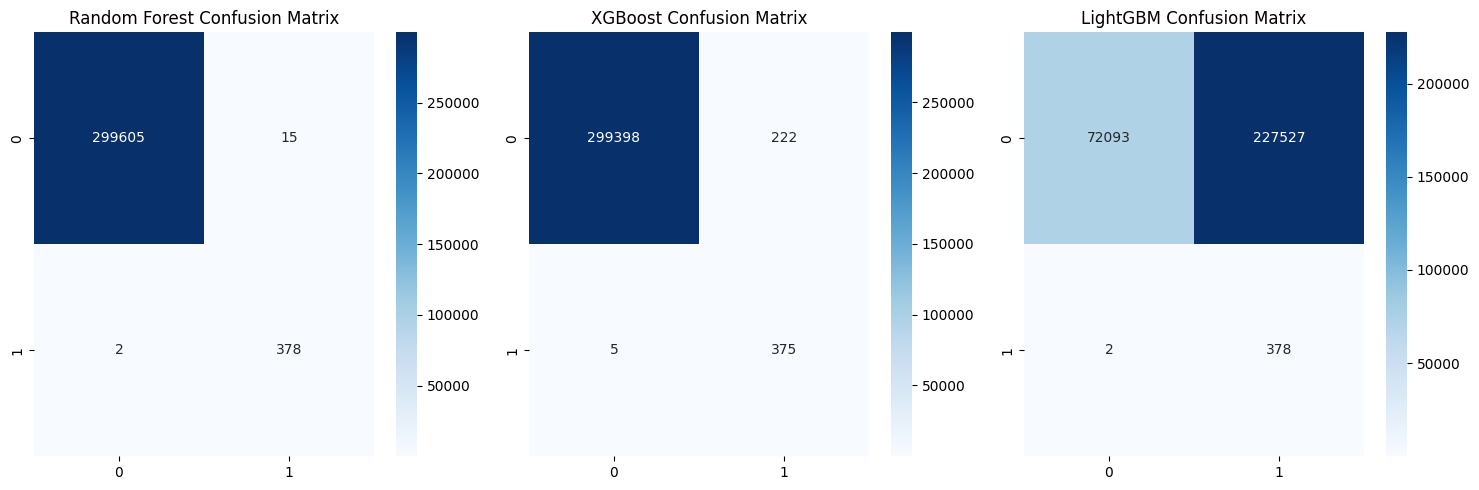

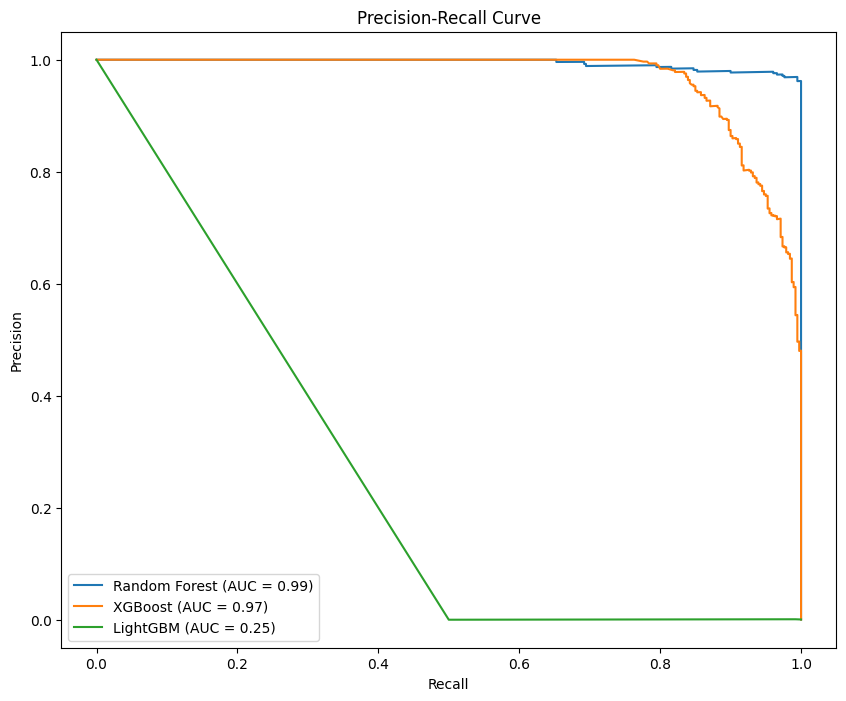

In [13]:
## 5. Model Evaluation
# Plot confusion matrices
plt.figure(figsize=(15, 5))
for i, (name, result) in enumerate(results.items(), 1):
    plt.subplot(1, 3, i)
    sns.heatmap(result["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
plt.tight_layout()
plt.show()

# Plot Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, result["y_prob"])
    plt.plot(recall, precision, label=f'{name} (AUC = {auc(recall, precision):.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

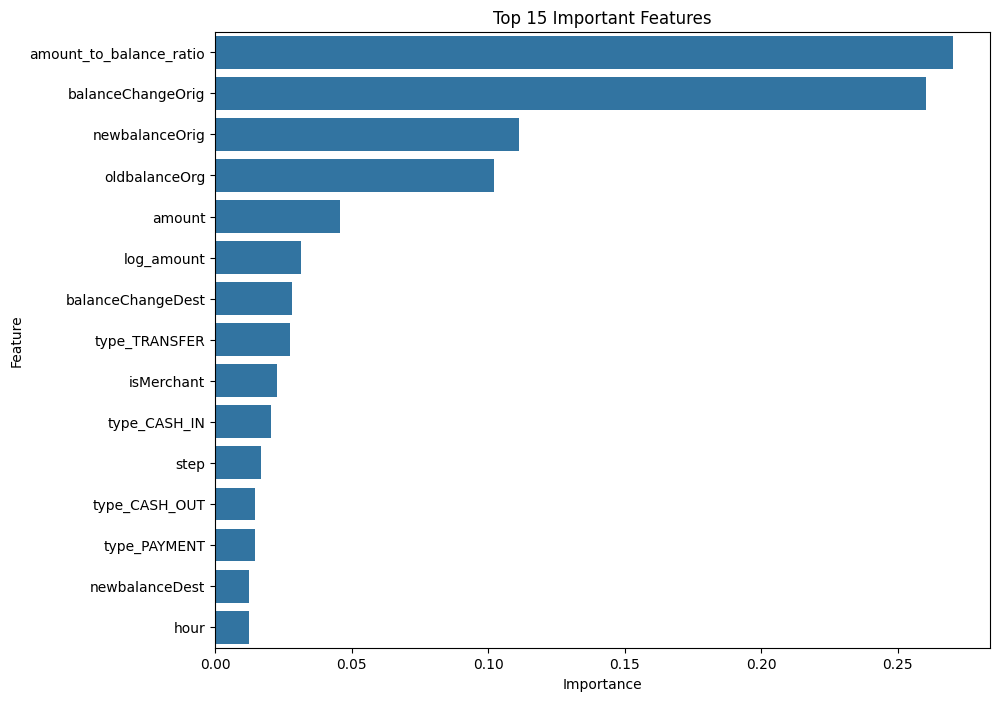

In [16]:
## 6. Feature Importance Analysis
# Plot feature importance for the best model
# Sort recall and precision values to ensure monotonicity for AUC calculation
best_model_name = max(results, key=lambda x: auc(precision_recall_curve(y_test, results[x]["y_prob"])[1], precision_recall_curve(y_test, results[x]["y_prob"])[0]))
best_model = results[best_model_name]["model"]

if hasattr(best_model, 'feature_importances_'):
    # For tree-based models
    importances = pd.DataFrame({
        'Feature': features,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importances.head(15))
    plt.title('Top 15 Important Features')
    plt.show()
elif hasattr(best_model, 'coef_'):
    # For linear models
    coefs = pd.DataFrame({
        'Feature': features,
        'Coefficient': best_model.coef_[0]
    }).sort_values('Coefficient', key=abs, ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Coefficient', y='Feature', data=coefs.head(15))
    plt.title('Top 15 Important Features')
    plt.show()

In [17]:
## 7. SHAP Analysis (for model interpretation)
# Note: This may take a while for large datasets
try:
    # Sample 1000 instances for SHAP (for performance)
    sample_idx = np.random.choice(X_test_scaled.shape[0], 1000, replace=False)
    X_sample = X_test_scaled[sample_idx]

    if 'XGB' in best_model_name or 'LightGBM' in best_model_name:
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_sample)

        # Summary plot
        plt.figure()
        shap.summary_plot(shap_values, X_sample, feature_names=features, plot_type="bar")
        plt.show()

        # Force plot for first prediction
        plt.figure()
        shap.force_plot(explainer.expected_value, shap_values[0,:], X_sample[0,:], feature_names=features)
        plt.show()
except Exception as e:
    print(f"SHAP analysis failed: {e}")

In [18]:
## 8. Save the Best Model
# Save the entire pipeline
pipeline = {
    'model': best_model,
    'scaler': scaler,
    'features': features,
    'metadata': {
        'dataset_size': len(df),
        'fraud_rate': y.mean(),
        'best_model': best_model_name
    }
}

joblib.dump(pipeline, 'fraud_detection_pipeline.pkl')

# Download the model file
files.download('fraud_detection_pipeline.pkl')

print("Pipeline saved and downloaded successfully!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Pipeline saved and downloaded successfully!
